This notebook contains extra work investigating unexpected data (mostly forms of duplication) in 'holdout_data.csv'.

In [2]:
import pandas as pd

In [3]:
# pull data
def load_and_clean(file):
    
    df = pd.read_csv(file)
    
    #standardize device column
    df['device'] = df['device'].str.lower()
    
    # record with invalid cohort '203902' has sessionid and userhash that do not appear under any other records
    # could assume cohort should be '202002', but as it is 1 record of 890k, just drop it
    df = df.drop(index = 846753)
    
    df_deduped = df.drop_duplicates()

    print(f'Original -> Deduped Data: {df.shape[0]:,} -> {df_deduped.shape[0]:,}')
    print(f'{(df.shape[0] - df_deduped.shape[0]):,} duplicate records removed')
    
    return df_deduped


# reload data to ensure correct processing
file_path = 'holdout_data.csv'

data = load_and_clean(file_path)

Original -> Deduped Data: 889,090 -> 846,755
42,335 duplicate records removed


# Complete Duplication

In [4]:
# read in data without cleaning
duped = pd.read_csv(file_path)

# all records that appear more than once
all_duplicates = duped[duped.duplicated(keep=False)]

# one each of the records that appear more than once
unique_duplicates = duped[duped.duplicated(keep='first')]

In [5]:
duped.shape

(889091, 11)

In [6]:
all_duplicates.shape

(72904, 11)

In [7]:
unique_duplicates.shape

(36893, 11)

In [8]:
# how many times does each duplicated record appear
duplication_counts = all_duplicates.groupby(all_duplicates.columns.tolist()).size().reset_index(name='count')

In [9]:
# get distribution of duplicate records across [control, treatment] and count conversions
dup_pivot = pd.pivot_table(
    unique_duplicates
    , values=['value', 'cohort']
    , index='group'
    , aggfunc='count'
)

dup_pivot

,cohort,value
group,,
control,5584,110
treatment,31309,524


In [10]:
dup_pivot_per = dup_pivot.div(len(unique_duplicates)) * 100

dup_pivot_per

,cohort,value
group,,
control,15.135663,0.298160
treatment,84.864337,1.420324


In [11]:
42335 / 889091

0.04761604830101756

### Observations:
* The dataset contains 36,893 records which appear 2 or more times, creating a set of 72,904 rows of duplicated data (8.2% of the raw data). Running .drop_duplicates() after a couple other data cleaning steps removes 42,335 duplicate records. These were dropped to avoid double counting conversions and conversion values.
* 85% of the duplicated records had group = 'treatment'.
* 1.4% of the duplicated rows were a conversion (non-null 'value').
* By dropping duplicates, we avoided double counting 634 conversions (out of a total 15,301 unique conversions).

# userhash assigned to both treatment and control

## userhash assigned to both treatment and control in same cohort

### Example:

In [12]:
data[data['userhash'] == '+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME='].sort_values('campaigntimestamp')

,agegroup,bidprice_usd,campaigntimestamp,cohort,device,gender,group,sessionid,userhash,value,verticalname
203196,31-35,0.0,2020-03-23 15:01:14,202003,mobile,f,control,39184472491,+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME=,NaN,Media and Entertainment
193383,18-25,0.0,2020-03-23 15:03:23,202003,mobile,f,control,39191448812,+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME=,NaN,Media and Entertainment
159713,31-35,0.0,2020-03-23 15:04:29,202003,desktop,f,treatment,39191448837,+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME=,NaN,Media and Entertainment
189810,26-30,0.0,2020-03-23 15:05:45,202003,mobile,f,treatment,39184472626,+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME=,NaN,Media and Entertainment
188793,41-45,0.0,2020-03-23 15:07:37,202003,tablet,f,treatment,39184472675,+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME=,NaN,Media and Entertainment


### Quantify prevalence: 

In [13]:
# displays full records for all userhash values which appear under both treatment and control within one cohort

users_in_both = data[['userhash', 'cohort', 'group']].groupby(['userhash', 'cohort']).nunique()
users_in_both = users_in_both[users_in_both['group'] > 1]


full = users_in_both.merge(data, how = 'left', on = ['userhash', 'cohort'])

In [14]:
full.sort_values(['userhash', 'campaigntimestamp'])[:20]

,userhash,cohort,group_x,agegroup,bidprice_usd,campaigntimestamp,device,gender,group_y,sessionid,value,verticalname
4,+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME=,202003,2,31-35,0.0000,2020-03-23 15:01:14,mobile,f,control,39184472491,NaN,Media and Entertainment
3,+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME=,202003,2,18-25,0.0000,2020-03-23 15:03:23,mobile,f,control,39191448812,NaN,Media and Entertainment
0,+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME=,202003,2,31-35,0.0000,2020-03-23 15:04:29,desktop,f,treatment,39191448837,NaN,Media and Entertainment
2,+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME=,202003,2,26-30,0.0000,2020-03-23 15:05:45,mobile,f,treatment,39184472626,NaN,Media and Entertainment
1,+PiBBdOu41dBLbu9+MuFlUk+dUk9vF1F0S2whBQU4ME=,202003,2,41-45,0.0000,2020-03-23 15:07:37,tablet,f,treatment,39184472675,NaN,Media and Entertainment
5,+VnmSNQkU/rsDIIQmmp41kZRIij7N1nTZs3+R041EXU=,202002,2,56-65,0.0000,2020-02-01 20:46:40,other,f,control,37347537277,NaN,Media and Entertainment
6,+VnmSNQkU/rsDIIQmmp41kZRIij7N1nTZs3+R041EXU=,202002,2,56-65,0.0000,2020-02-03 10:10:28,other,f,treatment,37441378927,NaN,Media and Entertainment
7,+gmz771FVOCXK9wG4MbAvjcGzRTiezANilF5vtoGq1w=,202004,2,56-65,0.0000,2020-04-13 00:05:54,tablet,NaN,control,39659539166,NaN,Media and Entertainment
8,+gmz771FVOCXK9wG4MbAvjcGzRTiezANilF5vtoGq1w=,202004,2,56-65,0.0000,2020-04-13 00:06:01,tablet,NaN,treatment,39659539166,NaN,Media and Entertainment
9,+gmz771FVOCXK9wG4MbAvjcGzRTiezANilF5vtoGq1w=,202004,2,56-65,0.5511,2020-04-13 00:06:04,tablet,NaN,treatment,39659539166,NaN,Media and Entertainment


Observations:
* Prevalence: only 91 userhash values out of 671,795 unique userhash's.
* This occurs in all five cohorts, across all device types.
* 87 out of 91 (96%) affected userhash values have gender = 'f'. Distribution in full dataset is 81% female.
* All occur under the 'Media and Entertainment' vertical.
* Only two records have non-zero bidprice_usd. Only one (different) record has non-zero 'value'.

## userhash assigned to both treatment and control, not necessarily in the same cohort

### Example:

In [15]:
data[data['userhash'] == '++2YQKgv1yPCFeUhIZhAT+hHNPGoT7sZFS2dERxVOUE=']

,agegroup,bidprice_usd,campaigntimestamp,cohort,device,gender,group,sessionid,userhash,value,verticalname
64516,41-45,0.0,2020-02-21 22:33:04,202002,mobile,f,treatment,38099577742,++2YQKgv1yPCFeUhIZhAT+hHNPGoT7sZFS2dERxVOUE=,NaN,Media and Entertainment
534334,41-45,0.0,2020-05-24 04:47:43,202005,mobile,f,control,40497500764,++2YQKgv1yPCFeUhIZhAT+hHNPGoT7sZFS2dERxVOUE=,NaN,Media and Entertainment


### Quantify prevalence:

In [16]:
users_in_both = data[['userhash', 'group']].groupby(['userhash']).nunique()
users_in_both = users_in_both[users_in_both['group'] > 1]


full = users_in_both.merge(data, how = 'left', on = ['userhash'])
full.sort_values(['userhash', 'campaigntimestamp'])

,userhash,group_x,agegroup,bidprice_usd,campaigntimestamp,cohort,device,gender,group_y,sessionid,value,verticalname
0,++2FUvEMcqSb+5aEXCPl/YJvDvvNLkIECvKZqyysUG8=,2,31-35,0.0,2020-02-02 16:27:15,202002,mobile,f,control,37383509068,NaN,Media and Entertainment
1,++2FUvEMcqSb+5aEXCPl/YJvDvvNLkIECvKZqyysUG8=,2,31-35,0.0,2020-05-16 08:28:43,202005,other,f,treatment,40345544296,NaN,Media and Entertainment
2,++2YQKgv1yPCFeUhIZhAT+hHNPGoT7sZFS2dERxVOUE=,2,41-45,0.0,2020-02-21 22:33:04,202002,mobile,f,treatment,38099577742,NaN,Media and Entertainment
3,++2YQKgv1yPCFeUhIZhAT+hHNPGoT7sZFS2dERxVOUE=,2,41-45,0.0,2020-05-24 04:47:43,202005,mobile,f,control,40497500764,NaN,Media and Entertainment
4,++7tUKaexzeTWol1bHGMb5ISiEiTJLUitvBed73RHik=,2,18-25,0.0,2020-03-31 08:10:49,202003,mobile,f,treatment,39367472569,NaN,Food and Beverage
...,...,...,...,...,...,...,...,...,...,...,...,...
67055,zzjNywzIp8Xd6ja4alebRb0NoaeRtPTigzQbr7cBdKQ=,2,41-45,0.0,2020-05-23 22:46:13,202005,desktop,f,treatment,abc406b0-428c-4566-9590-c67b8a1b8a8d,NaN,Retail
67056,zzlEwLHBYiK3vselhIakkTu5wKopNbU2eBR2GMJzudk=,2,31-35,0.0,2020-02-03 23:09:32,202002,other,f,control,37452335428,NaN,Media and Entertainment
67057,zzlEwLHBYiK3vselhIakkTu5wKopNbU2eBR2GMJzudk=,2,31-35,0.0,2020-06-18 04:16:57,202006,tablet,f,treatment,41049472937,NaN,Media and Entertainment
67058,zzsPqT7aBXjPh/8t3VAO/qFi+42Kg+E7qkHkLbEqlWM=,2,26-30,0.0,2020-03-31 08:34:22,202003,mobile,f,treatment,39366477060,NaN,Media and Entertainment


In [17]:
ranked = full.sort_values(['userhash', 'campaigntimestamp']).groupby('userhash')[['userhash', 'group_y']].rank(method='first')
ranked.columns = ['userhash_rank', 'group_rank']

concated = pd.concat([full, full.sort_values(['userhash', 'campaigntimestamp']).groupby('userhash')[['userhash', 'group_y']].rank()], axis=1)

In [18]:
concated

,userhash,group_x,agegroup,bidprice_usd,campaigntimestamp,cohort,device,gender,group_y,sessionid,value,verticalname,userhash,group_y
0,++2FUvEMcqSb+5aEXCPl/YJvDvvNLkIECvKZqyysUG8=,2,31-35,0.0,2020-02-02 16:27:15,202002,mobile,f,control,37383509068,NaN,Media and Entertainment,1.5,1.0
1,++2FUvEMcqSb+5aEXCPl/YJvDvvNLkIECvKZqyysUG8=,2,31-35,0.0,2020-05-16 08:28:43,202005,other,f,treatment,40345544296,NaN,Media and Entertainment,1.5,2.0
2,++2YQKgv1yPCFeUhIZhAT+hHNPGoT7sZFS2dERxVOUE=,2,41-45,0.0,2020-02-21 22:33:04,202002,mobile,f,treatment,38099577742,NaN,Media and Entertainment,1.5,2.0
3,++2YQKgv1yPCFeUhIZhAT+hHNPGoT7sZFS2dERxVOUE=,2,41-45,0.0,2020-05-24 04:47:43,202005,mobile,f,control,40497500764,NaN,Media and Entertainment,1.5,1.0
4,++7tUKaexzeTWol1bHGMb5ISiEiTJLUitvBed73RHik=,2,18-25,0.0,2020-03-31 08:10:49,202003,mobile,f,treatment,39367472569,NaN,Food and Beverage,1.5,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67055,zzjNywzIp8Xd6ja4alebRb0NoaeRtPTigzQbr7cBdKQ=,2,41-45,0.0,2020-05-23 22:46:13,202005,desktop,f,treatment,abc406b0-428c-4566-9590-c67b8a1b8a8d,NaN,Retail,1.5,2.0
67056,zzlEwLHBYiK3vselhIakkTu5wKopNbU2eBR2GMJzudk=,2,31-35,0.0,2020-02-03 23:09:32,202002,other,f,control,37452335428,NaN,Media and Entertainment,1.5,1.0
67057,zzlEwLHBYiK3vselhIakkTu5wKopNbU2eBR2GMJzudk=,2,31-35,0.0,2020-06-18 04:16:57,202006,tablet,f,treatment,41049472937,NaN,Media and Entertainment,1.5,2.0
67058,zzsPqT7aBXjPh/8t3VAO/qFi+42Kg+E7qkHkLbEqlWM=,2,26-30,0.0,2020-03-31 08:34:22,202003,mobile,f,treatment,39366477060,NaN,Media and Entertainment,1.5,2.0


### Observations:
* Some userhash values are first assigned to treatment and then to control in a later month/cohort.
* 26,426 users, id'd by userhash, are assigned to both control and treatment at some point during 6-month experiment. Haven't been able to quantify how many go from treatment -> control yet.

# Multiple group values (treatment, control) for one sessionid

### Example:
* moved from control to treatment in 1 second

In [19]:
data[data.sessionid == '37347375805']

,agegroup,bidprice_usd,campaigntimestamp,cohort,device,gender,group,sessionid,userhash,value,verticalname
13488,31-35,0.0,2020-02-01 02:45:24,202002,mobile,f,control,37347375805,TNn8ARDAsq0laO3jdEsk6BcgZVFwT9pcrnkc0tiz6U8=,NaN,Travel
13489,31-35,0.0,2020-02-01 02:45:25,202002,mobile,f,treatment,37347375805,TNn8ARDAsq0laO3jdEsk6BcgZVFwT9pcrnkc0tiz6U8=,NaN,Travel


### Quantify prevalence:

In [20]:
groups_per_sessionid = data[['sessionid', 'group']].groupby('sessionid').nunique()

groups_per_sessionid[groups_per_sessionid['group'] > 1]

,group
sessionid,
37347375805,2
39476436429,2
39621415808,2
39659539166,2
40892475656,2
41129489574,2


# Multiple bidprice_usd per sessionid

### Example:

In [21]:
data[data['sessionid'] == '37349381604']

,agegroup,bidprice_usd,campaigntimestamp,cohort,device,gender,group,sessionid,userhash,value,verticalname
25134,56-65,0.00000,2020-02-01 03:05:04,202002,desktop,m,treatment,37349381604,0bq71Q6xib6ZGBWMe0ugQxu47Wv6cMBpZeQz9hx9Jys=,NaN,Retail
25135,56-65,1.12410,2020-02-01 03:05:28,202002,desktop,m,treatment,37349381604,0bq71Q6xib6ZGBWMe0ugQxu47Wv6cMBpZeQz9hx9Jys=,64.4484,Retail
25136,56-65,1.04916,2020-02-01 03:05:28,202002,desktop,m,treatment,37349381604,0bq71Q6xib6ZGBWMe0ugQxu47Wv6cMBpZeQz9hx9Jys=,NaN,Retail


### Quantify prevalence:

In [22]:
# are we seeing multiple distinct bidprice_usd for the same sessionid?
nonzero_bid = data[data['bidprice_usd'] > 0]
dupe_sessions = nonzero_bid[nonzero_bid.duplicated('sessionid', keep=False)]

bid_per_sessionid = dupe_sessions.groupby('sessionid')[['bidprice_usd', 'campaigntimestamp']].nunique()
# yes, 390 sessionids appear in 2 records with same campaigntimestamp but different bidprice_usd

In [23]:
# are we seeing multiple NON-distinct bidprice-usd for the same sessionid?
same_bid_per_sessionid = dupe_sessions.groupby('sessionid')[['bidprice_usd', 'campaigntimestamp']].count()
# yes, 3,568 sessionids appear in 2 records with non-zero bidprice_usd (includes above 390)

In [24]:
# of the sessionids that come in multiple times with non-zero bidprice_usd, campaigntimestamp is constant per sessionid
bid_per_sessionid[bid_per_sessionid['campaigntimestamp'] > 1]

,bidprice_usd,campaigntimestamp
sessionid,,


In [25]:
# 390 sessionids come in with multiple distinct bidprice_usd values
bid_per_sessionid[bid_per_sessionid['bidprice_usd'] > 1]

,bidprice_usd,campaigntimestamp
sessionid,,
37349381604,2,1
37382506430,2,1
37417381263,2,1
37418382616,2,1
37441344079,2,1
...,...,...
abea05ad-97fc-4a3b-8ad0-df4b5f257f20,2,1
abea05ba-63da-4992-aab1-e1232b35ff6a,2,1
abea05dc-cbb3-48bd-af0f-54b0bf4ff628,2,1


In [26]:
# get sessionids with more than one distinct bidprice_usd
two_bids = bid_per_sessionid[bid_per_sessionid['bidprice_usd'] > 1]

# get full records for sessionids in two_bids
two_bids_full = data[data['sessionid'].isin(two_bids.index.to_list())]

# filter full records down to records with non-zero bidprice_usd
two_bids_full = two_bids_full[two_bids_full['bidprice_usd'] > 0][['sessionid', 'bidprice_usd', 'value']]

two_bids_full

,sessionid,bidprice_usd,value
5844,37441344079,2.69850,196.6050
5845,37441344079,2.50575,NaN
7094,37382506430,1.32249,NaN
7095,37382506430,1.52595,95.6262
10801,37461428658,1.12392,NaN
...,...,...,...
842888,abea0602-1675-52c7-b4fd-5518b5c34a27,1.34017,NaN
842991,abe9062e-102d-4f3d-c30e-8589ba72624d,0.66900,44.6000
842992,abe9062e-102d-4f3d-c30e-8589ba72624d,0.57980,NaN
846065,abea05ba-63da-4992-aab1-e1232b35ff6a,0.55104,NaN


In [27]:
# filter to records where value is NaN
two_bids_zeroval = two_bids_full[~(two_bids_full['value'] > 0)]
two_bids_zeroval = two_bids_zeroval.drop(['value'], axis=1)
two_bids_zeroval.columns = ['sessionid', 'bid_zero']


# filter to records where value is > 0
two_bids_val = two_bids_full[two_bids_full['value'] > 0]
two_bids_val.columns = ['sessionid', 'bid_val', 'value']

# join together tables to create one row per sessionid with both bidprice_usds: the one tied to a non-null conversion 'value' and the one tied to NaN 'value'
two_bids_joined = two_bids_zeroval.merge(two_bids_val, how='outer', on='sessionid')

# calculate relative difference between two bidprice_usd values
two_bids_joined['bid_diff'] = (two_bids_joined['bid_val'] - two_bids_joined['bid_zero']) / two_bids_joined['bid_zero']

<Axes: title={'center': 'Relative diff b/w bidprices tied to nonzero value and zero value'}, ylabel='Frequency'>

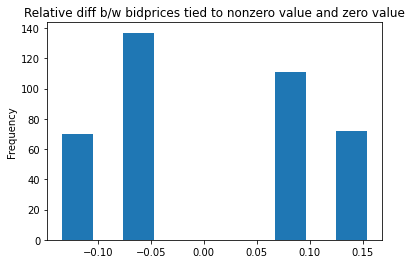

In [28]:
# plot histogram of these differences
two_bids_joined['bid_diff'].plot.hist(title = 'Relative diff b/w bidprices tied to nonzero value and zero value')

### Observations:
* 3,568 out of 773,656 unique sessionids appear with multiple nonzero bidprice_usd values
* 390 sessionids appear with multiple **distinct** bidprice_usd values. They differ by at most 15%
* 6k? instances of (sessionid, bidprice_usd, campaigntimestamp) tuples coming in twice: one with value = 0, one with value >0
    * I assume we should only be counting one of these for the value per transaction? seems like double counting to include both
    * As with the overall duplicates, are certain devices, verticals, etc seeing this duplication more often?

# Pairs of Records identical except one has 'value' = NaN, one has actual 'value'

### Example:

In [29]:
data[data['userhash'] == 'zz0iMt1XTix+PuJkdvQAI7PnG+HXQZHtIgcPAA2JPdc=']

,agegroup,bidprice_usd,campaigntimestamp,cohort,device,gender,group,sessionid,userhash,value,verticalname
19884,41-45,0.0,2020-02-05 00:00:34,202002,desktop,f,treatment,37491335441,zz0iMt1XTix+PuJkdvQAI7PnG+HXQZHtIgcPAA2JPdc=,202.0303,Media and Entertainment
19885,41-45,0.0,2020-02-05 00:00:34,202002,desktop,f,treatment,37491335441,zz0iMt1XTix+PuJkdvQAI7PnG+HXQZHtIgcPAA2JPdc=,NaN,Media and Entertainment
